# Install libraries

In [15]:
%%capture
!pip install gdown
!pip install transformers datasets evaluate
!pip install accelerate -U
!pip install -U adapters
!nvidia-smi

In [3]:
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/drive')

import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a deepHW2 folder and put all the files under Q1 folder, then 'deepHW2/Q1'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Deep Learning Final Proj'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))


import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

fully_connected_networks_path = os.path.join(GOOGLE_DRIVE_PATH, 'utility.py')
fully_connected_networks_edit_time = time.ctime(os.path.getmtime(fully_connected_networks_path))
print('cnn.py last edited on %s' % fully_connected_networks_edit_time)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mounted at /content/drive
['myproject_1.ipynb', 'myproject.ipynb', 'utility.py', 'FineTunning.ipynb']
cnn.py last edited on Thu Feb  1 05:54:33 2024


# Import libraries

In [16]:
from transformers import BertForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, set_seed
from transformers import DataCollatorWithPadding
import torch.nn as nn
import logging
import torch
import evaluate
import utility
import adapters
import time
import warnings
import random
import numpy as np
warnings.filterwarnings('ignore', category=UserWarning)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
Seed = 42
random.seed(Seed)
np.random.seed(Seed)
torch.manual_seed(Seed)
set_seed(Seed)

# Process on data

## Downloading and Processing Datasets

In this section, we download and process the training and development datasets.


In [9]:
data_handler = utility.DataHandler()
data_handler.download_and_process_datasets(Download = True)


Downloading...
From (original): https://drive.google.com/uc?id=1k5LMwmYF7PF-BzYQNE2ULBae79nbM268
From (redirected): https://drive.google.com/uc?id=1k5LMwmYF7PF-BzYQNE2ULBae79nbM268&confirm=t&uuid=e4c424f4-ee65-4a3a-9fd2-3b4631946faa
To: /content/Dataset/subtaskB_train.jsonl
100%|██████████| 155M/155M [00:00<00:00, 248MB/s]
Downloading...
From: https://drive.google.com/uc?id=1oh9c-d0fo3NtETNySmCNLUc6H1j4dSWE
To: /content/Dataset/subtaskB_dev.jsonl
100%|██████████| 4.93M/4.93M [00:00<00:00, 180MB/s]


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

## Tokenization of Datasets

In this section, we tokenize the training and validation datasets using the BERT-based tokenizer.

In [10]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
id2label = {0 :'human', 1 :'chatGPT', 2 :'cohere', 3 :'davinci', 4 :'bloomz', 5 :'dolly'}
label2id = {'human': 0, 'chatGPT': 1, 'cohere': 2, 'davinci': 3, 'bloomz': 4, 'dolly': 5}


tokenized_ds_train, tokenized_ds_val = data_handler.tokenize_datasets(tokenizer)

Map:   0%|          | 0/71027 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

## Plot Distribution of Labels in Dataset

In this section, we visualize the distribution of labels in the training and validation datasets using a distribution plot.

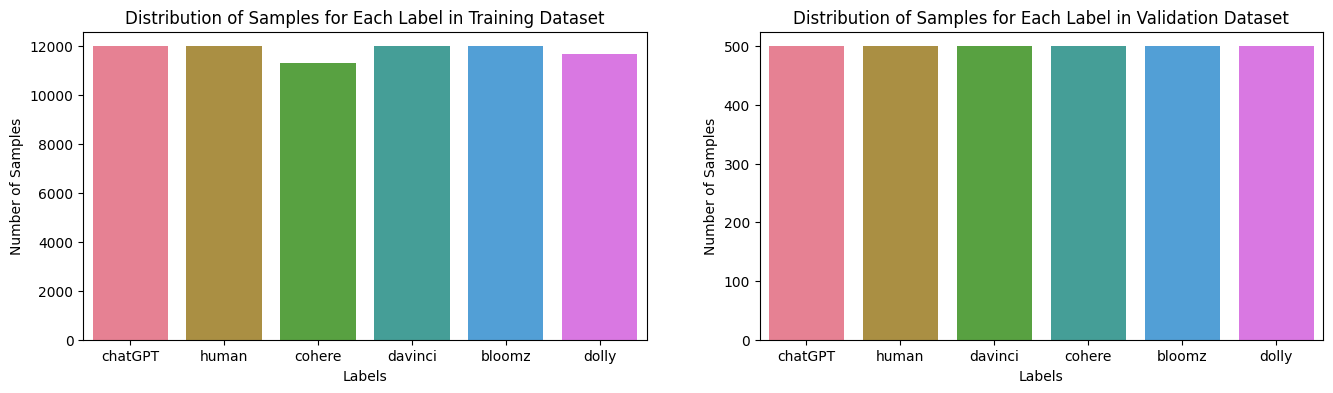


Label Counts for Training Dataset:
chatGPT: 11995
human: 11997
cohere: 11336
davinci: 11999
bloomz: 11998
dolly: 11702

Label Counts for Validation Dataset:
chatGPT: 500
human: 500
davinci: 500
cohere: 500
bloomz: 500
dolly: 500





In [11]:
data_handler.distribution_plot(tokenized_ds_train, tokenized_ds_val, id2label, output_filename='Part_One_Dataset_distribution_plot.png')


# FineTune Bert

## Model Initialization

In this section, we initialize four different instances of the BERT-based sequence classification model with varying percentages of labeled data.

In [13]:
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)


model_OnePercent = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6, id2label=id2label, label2id=label2id)
model_FivePercent = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6, id2label=id2label, label2id=label2id)
model_TenPercent = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6, id2label=id2label, label2id=label2id)
model_FiftyPercent = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6, id2label=id2label, label2id=label2id)

model_OnePercent_adapter = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6, id2label=id2label, label2id=label2id)
model_FivePercent_adapter = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6, id2label=id2label, label2id=label2id)
model_TenPercent_adapter = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6, id2label=id2label, label2id=label2id)
model_FiftyPercent_adapter = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6, id2label=id2label, label2id=label2id)

we initialize an evaluation metric for accuracy, a data collator with padding using the specified tokenizer, and determine the available computing device.

In [14]:
metric = evaluate.load('accuracy')
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding='longest')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Training Model with 1% Labeled Data

In this section, we prepare and visualize 1% of the labeled training and validation data, then train the BERT-based sequence classification model (`model_OnePercent`) using this subsampled data.

In [17]:
data_valid = tokenized_ds_val.shuffle(seed=42)

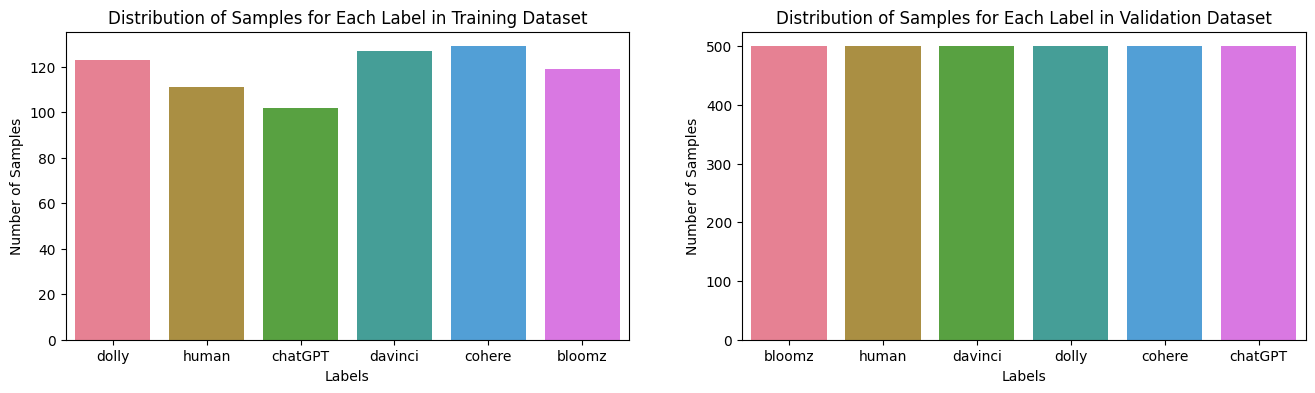


Label Counts for Training Dataset:
dolly: 123
human: 111
chatGPT: 102
davinci: 127
cohere: 129
bloomz: 119

Label Counts for Validation Dataset:
bloomz: 500
human: 500
davinci: 500
dolly: 500
cohere: 500
chatGPT: 500





You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.775599,0.176667
2,No log,1.725711,0.198000
3,No log,1.651550,0.317000
4,No log,1.733148,0.257333
5,No log,1.665223,0.291667


In [18]:
data_train_onePrecet = tokenized_ds_train.shuffle(seed=42).shard(num_shards=100, index=0)


data_handler.distribution_plot(data_train_onePrecet, data_valid, id2label, output_filename='Part_One_Distribution_One_Percent.png')

# Train
OnePercent = utility.train_model(model=model_OnePercent,
                         train_set=data_train_onePrecet,
                         val_set=data_valid,
                         epochs=5,
                         batch_size=64,
                         tokenizer = tokenizer,
                         data_collator = data_collator,
                         metric = metric,
                         device = device,
                         seed_value = 42
                         )


**Training Model wit 1% Labeled Data - Adapter**

In [21]:
from adapters import ConfigUnion, BnConfig, ParBnConfig, AutoAdapterModel, SeqBnInvConfig

adapters.init(model_OnePercent_adapter)
adapter_config = BnConfig(mh_adapter=True, output_adapter=True, reduction_factor=8, non_linearity="gelu")
model_OnePercent_adapter.add_adapter("my_adapter", config=adapter_config, set_active=True)
model_OnePercent_adapter.set_active_adapters("my_adapter")
model_OnePercent_adapter.train_adapter("my_adapter")

OnePercent_adapter = utility.train_model(model=model_OnePercent_adapter,
                                          train_set=data_train_onePrecet,
                                          val_set=data_valid,
                                          epochs=5,
                                          batch_size=64,
                                          tokenizer = tokenizer,
                                          data_collator = data_collator,
                                          metric = metric,
                                          device = device,
                                          seed_value = 42
                                          )

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.496872,0.365333
2,No log,1.508193,0.361333
3,No log,1.514861,0.362667
4,No log,1.520860,0.362333
5,No log,1.521540,0.361667


There were missing keys in the checkpoint model loaded: ['bert.prompt_tuning.base_model_embeddings.weight'].


## Training Model with 5% Labeled Data

In this section, we prepare and visualize 5% of the labeled training and validation data, then train the BERT-based sequence classification model (`model_FivePercent`) using this subsampled data.

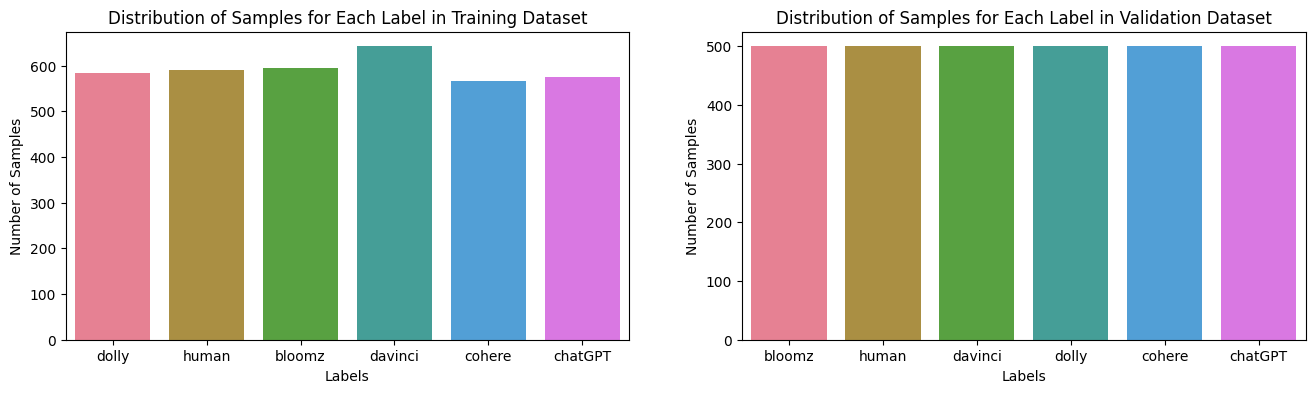


Label Counts for Training Dataset:
dolly: 583
human: 591
bloomz: 595
davinci: 642
cohere: 567
chatGPT: 574

Label Counts for Validation Dataset:
bloomz: 500
human: 500
davinci: 500
dolly: 500
cohere: 500
chatGPT: 500





Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.570891,0.348667
2,No log,1.264005,0.460000
3,No log,1.390307,0.467667
4,No log,1.558690,0.467000
5,No log,1.664080,0.465667


In [20]:
data_train_FivePercent = tokenized_ds_train.shuffle(seed=42).shard(num_shards=20, index=0)


data_handler.distribution_plot(data_train_FivePercent, data_valid, id2label, output_filename='Part_One_Distribution_Five_Percent.png')

# Train

FivePercent = utility.train_model(model=model_FivePercent,
                         train_set=data_train_FivePercent,
                         val_set=data_valid,
                         epochs=5,
                         batch_size=64,
                         tokenizer = tokenizer,
                         data_collator = data_collator,
                         metric = metric,
                         device = device,
                         seed_value = 42
                         )

**Training Model with 5% Labeled Data**

In [24]:
#from adapters import ConfigUnion, BnConfig, ParBnConfig, AutoAdapterModel, SeqBnInvConfig

adapters.init(model_FivePercent_adapter)
adapter_config = BnConfig(mh_adapter=True, output_adapter=True, reduction_factor=8, non_linearity="gelu")
model_FivePercent_adapter.add_adapter("my_adapter", config=adapter_config, set_active=True)
model_FivePercent_adapter.set_active_adapters("my_adapter")
model_FivePercent_adapter.train_adapter("my_adapter")

# Train

FivePercent_adapter = utility.train_model(model=model_FivePercent_adapter,
                         train_set=data_train_FivePercent,
                         val_set=data_valid,
                         epochs=5,
                         batch_size=64,
                         tokenizer = tokenizer,
                         data_collator = data_collator,
                         metric = metric,
                         device = device,
                         seed_value = 42
                         )

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.788680,0.215333
2,No log,1.782657,0.240333
3,No log,1.778778,0.261667
4,No log,1.777277,0.235333
5,No log,1.776382,0.242333


There were missing keys in the checkpoint model loaded: ['bert.prompt_tuning.base_model_embeddings.weight'].


## Training Model with 10% Labeled Data

In this section, we prepare and visualize 10% of the labeled training and validation data, then train the BERT-based sequence classification model (`model_TenPercent`) using this subsampled data.

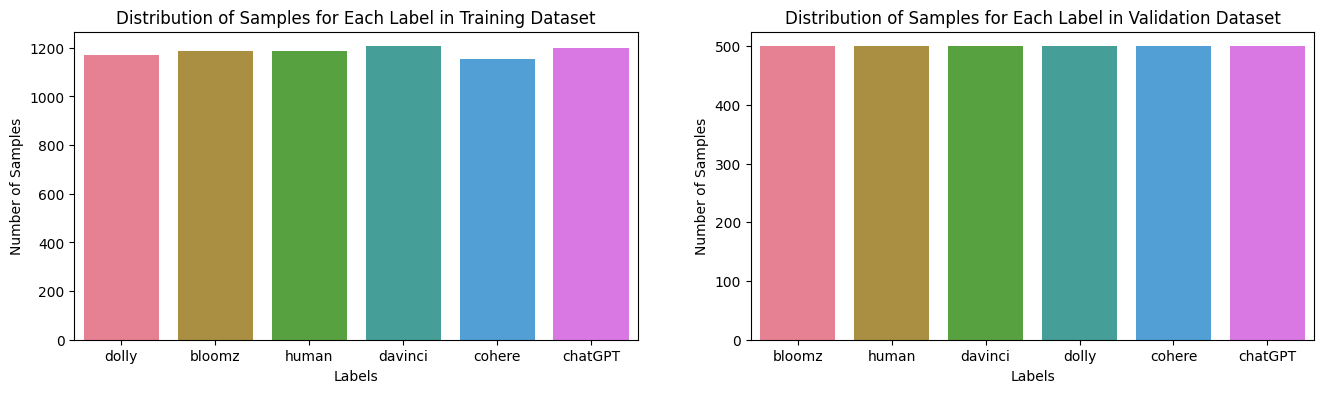


Label Counts for Training Dataset:
dolly: 1170
bloomz: 1188
human: 1187
davinci: 1206
cohere: 1154
chatGPT: 1198

Label Counts for Validation Dataset:
bloomz: 500
human: 500
davinci: 500
dolly: 500
cohere: 500
chatGPT: 500





Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.362722,0.449667
2,No log,1.333085,0.518000
3,No log,1.541718,0.516667
4,No log,1.809150,0.523000
5,No log,1.967227,0.517333


In [25]:
data_train_TenPercent = tokenized_ds_train.shuffle(seed=42).shard(num_shards=10, index=0)


data_handler.distribution_plot(data_train_TenPercent, data_valid, id2label, output_filename='Part_One_Distribution_Ten_Percent.png')

# Train

TenPercent = utility.train_model(model=model_TenPercent,
                         train_set=data_train_TenPercent,
                         val_set=data_valid,
                         epochs=5,
                         batch_size=64,
                         tokenizer = tokenizer,
                         data_collator = data_collator,
                         metric = metric,
                         device = device,
                         seed_value = 42
                         )

**Training Model with 10% Labeled Data- Adapter**

In [30]:
#from adapters import ConfigUnion, BnConfig, ParBnConfig, AutoAdapterModel, SeqBnInvConfig
model_TenPercent_adapter = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6, id2label=id2label, label2id=label2id)

adapters.init(model_TenPercent_adapter)
adapter_config = BnConfig(mh_adapter=True, output_adapter=True, reduction_factor=2, non_linearity="relu")
model_TenPercent_adapter.add_adapter("my_adapter", config=adapter_config, set_active=True)
model_TenPercent_adapter.set_active_adapters("my_adapter")
model_TenPercent_adapter.train_adapter("my_adapter")


TenPercent_adapter = utility.train_model(model=model_TenPercent_adapter,
                         train_set=data_train_TenPercent,
                         val_set=data_valid,
                         epochs=5,
                         batch_size=16,
                         tokenizer = tokenizer,
                         data_collator = data_collator,
                         metric = metric,
                         device = device,
                         seed_value = 42
                         )


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.775709,0.230000
2,No log,1.760874,0.249333
3,No log,1.752193,0.289000
4,No log,1.748417,0.273333
5,No log,1.746588,0.291333


There were missing keys in the checkpoint model loaded: ['bert.prompt_tuning.base_model_embeddings.weight'].


## Training Model with 50% Labeled Data

In this section, we prepare and visualize 50% of the labeled training and validation data, then train the BERT-based sequence classification model (`model_FiftyPercent`) using this subsampled data.

In [ ]:
data_train_FiftyPercent = tokenized_ds_train.shuffle(seed=42).shard(num_shards=2, index=0)


data_handler.distribution_plot(data_train_FiftyPercent, data_valid, id2label, output_filename='Part_One_Distribution_Fifty_Percent.png')

# Train

FiftyPercent = utility.train_model(model=model_FiftyPercent,
                         train_set=data_train_FiftyPercent,
                         val_set=data_valid,
                         epochs=5,
                         batch_size=64,
                         tokenizer = tokenizer,
                         data_collator = data_collator,
                         metric = metric,
                         device = device,
                         seed_value = 42
                         )

**Training Model with 50% Labeled Data - Adapter**

In [32]:
#from adapters import ConfigUnion, BnConfig, ParBnConfig, AutoAdapterModel, SeqBnInvConfig
#model_FiftyPercent_adapter = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6, id2label=id2label, label2id=label2id)

adapters.init(model_FiftyPercent_adapter)
adapter_config = BnConfig(mh_adapter=True, output_adapter=True, reduction_factor=2, non_linearity="relu")
model_FiftyPercent_adapter.add_adapter("my_adapter", config=adapter_config, set_active=True)
model_FiftyPercent_adapter.set_active_adapters("my_adapter")
model_FiftyPercent_adapter.train_adapter("my_adapter")

FiftyPercent_adapter = utility.train_model(model=model_FiftyPercent_adapter,
                         train_set=data_train_FiftyPercent,
                         val_set=data_valid,
                         epochs=10,
                         batch_size=16,
                         tokenizer = tokenizer,
                         data_collator = data_collator,
                         metric = metric,
                         device = device,
                         seed_value = 42
                         )

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.721537,0.287333
2,No log,1.689924,0.264333
3,No log,1.662162,0.310333
4,No log,1.650731,0.311333
5,No log,1.645269,0.314333
6,No log,1.634006,0.324667
7,No log,1.628528,0.327667
8,No log,1.628614,0.324667
9,No log,1.625561,0.321000
10,No log,1.624899,0.324333


There were missing keys in the checkpoint model loaded: ['bert.prompt_tuning.base_model_embeddings.weight'].


## Plotting Accuracy vs. Percentage of Labeled Data

In this section, we visualize the accuracy of the BERT-based sequence classification model at different percentages of labeled data.


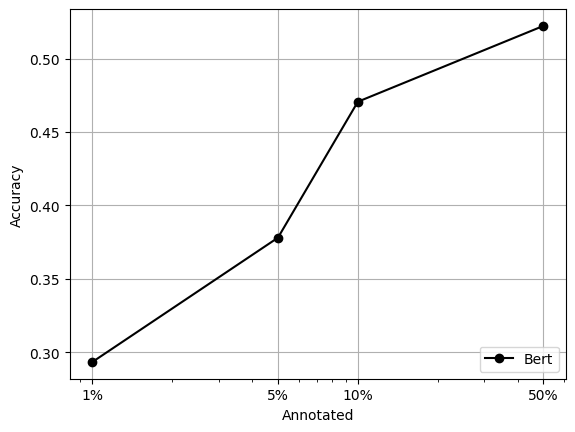

In [ ]:
percentages = [1, 5, 10, 50]
bert_accuracies = [OnePercent[-1], FivePercent[-1], TenPercent[-1], FiftyPercent[-1]]

utility.plot_accuracy_vs_percentage(percentages, bert_accuracies, label='Bert')

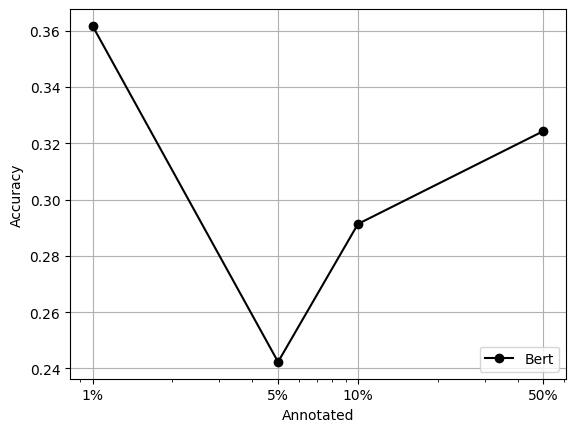

In [33]:
percentages = [1, 5, 10, 50]
bert_accuracies_adapter = [OnePercent_adapter[-1], FivePercent_adapter[-1], TenPercent_adapter[-1], FiftyPercent_adapter[-1]]

utility.plot_accuracy_vs_percentage(percentages, bert_accuracies_adapter, label='Bert')

Saving Accuracy for Part Three:

In [35]:
import pickle

with open('bert_accuracies.pkl', 'wb') as file:
    pickle.dump(bert_accuracies_adapter, file)